# Odds Ratio

Odds ratio provides an intuitive measure of association strength between genetic variants and **binary outcomes** (like disease status) by comparing the odds of disease given a particular genotype to the odds without it, while logistic regression extends this concept to model the log-odds of disease as a linear function of genetic markers, allowing for multiple variants and covariates to be analyzed simultaneously.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide8.png)

# Key Formula

In logistic regression for genetic association studies, we model the probability of a binary outcome (e.g., disease status) as a function of genetic markers:

$$
\text{logit}(p_i) = \ln\left(\frac{p_i}{1-p_i}\right) = b_0 + \beta X_i
$$

Where:
- $p_i=P(Y_i=1)$ is the probability of being a case for a specific disease for individual $i$
- $\frac{p_i}{1-p_i}$ is the odds of disease for individual $i$
- $X_i$ is the genotype for individual $i$ at a single marker (e.g., coded as 0, 1, 2 for the number of minor alleles)
- $b_0$ is the intercept
- $\beta$ is the log odds ratio per unit increase of $X$ in $Y$ (to be estimated)


# Technical Details


## Odds

The odds for an event with probability $p$ is defined as:

$$
\text{Odds} = \frac{p}{1-p}
$$

For example, if the probability of disease is 0.2 (20%), then the odds of disease are $\frac{0.2}{0.8} = 0.25$, or 1:4.

## Odds Ratio

The odds ratio compares the odds of disease between two groups. For a genetic variant with genotypes AA, Aa, and aa (where `a` is the risk allele), the odds ratio for aa vs. AA would be:

$$
\text{OR} = \frac{\text{Odds(Disease|aa)}}{\text{Odds(Disease|AA)}}
$$

Then the odds ratio (OR) can be calculated as:

$$
\text{OR} = e^{\beta}
$$


## Interpretation in Genetics

- $\text{OR} = 1$: No association between genotype and disease
- $\text{OR} > 1$: The variant increases disease risk (e.g., OR = 2 means individuals with this genotype have twice the odds of disease)
- $\text{OR} < 1$: The variant decreases disease risk (protective effect)

# Example

This example demonstrates a genetic association analysis workflow for studying potential relationships between genetic variants and disease status (binary). The key steps include:

1. Create the genotype and phenotype data for 5 individuals across 3 genetic variants and scale the matrix
2. Assign disease status to each individual (case/control)
3. Perform univariate logistic regression for each variant
4. Calculate key statistical measures: beta coefficients, odds ratios, standard errors, z-scores, p-values and generate the summary statistics results


Related topics:
- [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html)

In [1]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5
M = 3
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}

X <- scale(Xraw_additive, center = TRUE, scale = TRUE)


Now instead of the continuous trait like we did in [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html), now we observe if an individual is a case (1) or a control (0) and denote as `Y`:

In [3]:
# assign observed disease status for the 5 individuals (1: case, 0: control)
Y <- c(0, 1, 0, 1, 0)

# Create a data frame for analysis
data <- data.frame(
  Y = Y,
  variant1 = X[,1],
  variant2 = X[,2],
  variant3 = X[,3]
)
data

Y variant1   variant2   variant3  
Individual 1 0 -0.6708204  0.2390457  0.4472136
Individual 2 1  1.5652476 -0.9561829 -0.6708204
Individual 3 0  0.4472136  0.2390457 -0.6708204
Individual 4 1 -0.6708204 -0.9561829 -0.6708204
Individual 5 0 -0.6708204  1.4342743  1.5652476

Then we fit a logistic regression model for each variant using all individuals:

In [4]:
# Univariate Logistic Regression Model
beta <- numeric(M)
odds_ratios <- numeric(M)
se_beta <- numeric(M)
z_score <- numeric(M)
p_value <- numeric(M)

for (j in 1:M) {
  formula <- as.formula(paste("Y ~", paste0("variant", j)))
  model <- glm(formula, data = data, family = binomial())
  
  # Extract coefficient and calculate odds ratio
  coef_summary <- summary(model)$coefficients
  beta[j] <- coef_summary[2, 1]  # Log odds ratio
  odds_ratios[j] <- exp(beta[j]) # odds ratio is the exponent of the beta from the regression
  se_beta[j] <- coef_summary[2, 2]  # Standard error  
  z_score[j] <- beta[j] / se_beta[j]
  p_value[j] <- round(coef_summary[2, 4], 4)  # Two-tailed p-value
}


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


This warning occurs because with only 5 individuals, the logistic regression model is trying to fit a line that perfectly separates the cases (Y=1) from controls (Y=0), resulting in predicted probabilities of exactly 0 or 1. This leads to numerical instability and unreliable coefficient estimates - it's a form of "complete separation" that's common with very small sample sizes in logistic regression.

The logistic results are:

In [5]:
# Create results table
logistic_results <- data.frame(Variant = colnames(X), BETA = beta, OR = odds_ratios, SE = se_beta, Z = z_score, P_Value = p_value)
logistic_results

Variant   BETA        OR           SE           Z             P_Value
1 Variant 1   0.9826287 2.671470e+00     1.145783  0.8576046390 0.3911 
2 Variant 2 -39.4255886 7.545437e-18 67380.071390 -0.0005851224 0.9995 
3 Variant 3 -17.6886034 2.079396e-08  7555.904101 -0.0023410307 0.9981

# Supplementary

## Graphical Summary

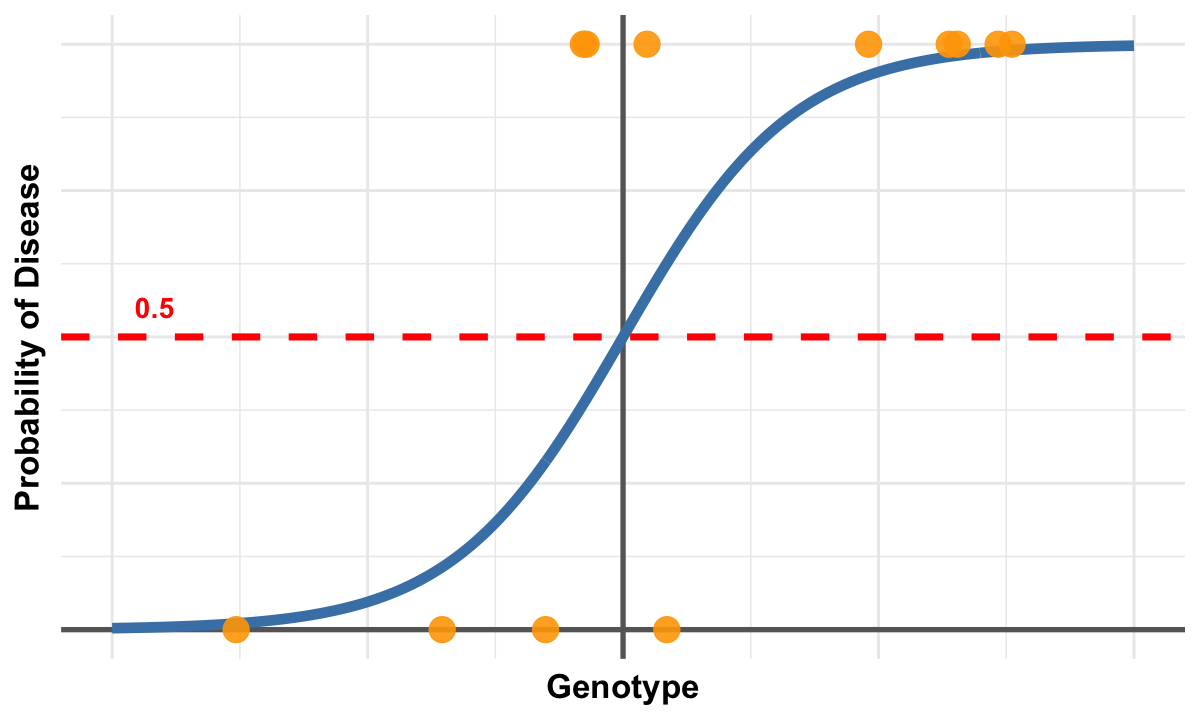

In [6]:
# Load necessary library
library(ggplot2)

# Set plot size
options(repr.plot.width = 10, repr.plot.height = 6)

# Define logistic function
logistic <- function(x, beta0 = 0, beta1 = 1) {
  1 / (1 + exp(-(beta0 + beta1 * x)))
}

# Generate logistic curve
x_vals <- seq(-6, 6, length.out = 300)
y_vals <- logistic(x_vals)
curve_data <- data.frame(x = x_vals, y = y_vals)

# Simulate fewer binary data points
set.seed(123)
x_sim <- runif(12, min = -5, max = 5)
prob <- logistic(x_sim)
y_sim <- rbinom(length(x_sim), size = 1, prob = prob)
points_data <- data.frame(x = x_sim, y = y_sim)

# Plot
p <- ggplot() +
  geom_hline(yintercept = 0, color = "gray40", linewidth = 1.5) +
  geom_vline(xintercept = 0, color = "gray40", linewidth = 1.5) +
  geom_line(data = curve_data, aes(x = x, y = y), 
            color = "steelblue", linewidth = 3) +
  geom_point(data = points_data, aes(x = x, y = y), 
             color = "orange", size = 7, alpha = 0.9) +
  geom_hline(yintercept = 0.5, linetype = "dashed", 
             color = "red", linewidth = 2) +
  annotate("text", x = -5.5, y = 0.55, label = "0.5", 
           color = "red", size = 6, fontface = "bold") +
  labs(x = "Genotype", y = "Probability of Disease") +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_blank(),
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank()
    # Y-axis title left at default angle (90 degrees)
  )
print(p)

# Save with transparent background
ggsave("./cartoons/odds_ratio.png", plot = p, 
       width = 10, height = 6, 
       bg = "transparent", 
       dpi = 300)
